In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random as python_random

# #Let's Examine Correlation between the series
# ###https://github.com/mikekeith52/scalecast-examples/blob/main/multivariate/multivariate.ipynb
import useful_functions as uf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential#, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1_l2
from datetime import timedelta


In [2]:
# load the data
#file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/BR_param_EDA.csv'
#file_path = '../data/data_cleaned_RF.csv'
file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'
# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
# define the target variable as the first column
target_variable = df_raw.columns[0]
# Convert all columns to float
df_raw = df_raw.astype('float64')

# Remove outliers
#remove_outliers_threshold = np.nan
remove_outliers_threshold = 0.20

In [3]:
# Check if there is any NA value
#print(df_raw.isna().sum())

# If we want to remove outliers
if not pd.isna(remove_outliers_threshold):
    df_cleaned = uf.remove_outliers(df_raw.copy(), threshold=remove_outliers_threshold)
else:
    df_cleaned = df_raw.copy()

# Fill missing values
df_adjusted = uf.fill_missing_values(df_cleaned)

In [4]:
# Check if there is any collum with unique values and drop it
for column in df_adjusted.columns:
    if len(df_adjusted[column].unique()) == 1:
        df_adjusted.drop(column, axis=1, inplace=True)

#print(df_adjusted.shape)

In [5]:
# Define test and validation set sizes
val_size = 48 # 48 months or 4 years
test_size = 48 # 48 months or 4 years

# Split the data into train and test sets
train_raw_total = df_adjusted.copy()[:-test_size] # This total trainning set will be used to train the final model
train_raw = train_raw_total[:-val_size]
val_raw = train_raw_total[-val_size:]
test_raw = df_adjusted.copy()[-test_size:]

# # FIll missing values
df_train = uf.fill_missing_values(train_raw)
df_val = uf.fill_missing_values(val_raw)
df_test = uf.fill_missing_values(test_raw)


In [6]:
# Let´s scale the dfs

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train)
scaled_val = scaler.transform(df_val)
scaled_test = scaler.transform(df_test)
# include df columns names in the train and test sets
train = pd.DataFrame(scaled_train, columns=df_train.columns)
val = pd.DataFrame(scaled_val, columns=df_val.columns)
test = pd.DataFrame(scaled_test, columns=df_test.columns)
# Include the index in the train and test sets
train.index = df_train.index
val.index = df_val.index
test.index = df_test.index


Reshape your data

In [7]:
# Converting the series to samples
# We will use the past X months to predict the value in the horizon future
def createXY(dataset, n_past, n_future):
    dataX, dataY = [], []
    # Loop for the entire dataset
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)  # Past n months
        dataY.append(dataset.iloc[i + n_future - 1, 0])  #
    return np.array(dataX), np.array(dataY)

n_past = 12  # Number of past months to use
n_future = 12  # Horizon to predict

# Create the samples
X_train, Y_train = createXY(train, n_past, n_future)
X_val, Y_val = createXY(val, n_past, n_future)
X_test, Y_test = createXY(test, n_past, n_future)


### Let's create a model with the best parameters

In [8]:
# Let´s define the seed for reproducibility

def func_set_seed(seed=42):
    np.random.seed(seed)
    python_random.seed(seed)
    set_seed(seed) #tensorflow.random.set_seed(seed)

# Call the function to set the seed
func_set_seed(42)

In [9]:
best_params = {
    "gru_units": {1: 250,  2: 40, 3: 10},
    "n_layers": 1,
    "learning_rate": 0.001,
    "optimizer":  'rmsprop', # 'adam' or 'rmsprop'
    "epochs": 75,
    "batch_size":32,
    "dropout_rate": 0.10,
    #"alphas_l1_l2": 0.01,
}

In [10]:
### Build a GRU model testing different parameters
best_epochs = best_params.pop('epochs')
best_batch_size = best_params.pop('batch_size')
# Function to build the model
def build_model(n_layers, optimizer, learning_rate, 
                gru_units,
                #alphas_l1_l2,
                dropout_rate):
    # Check the optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model = Sequential()
    # Define the input layer shape
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    # Add the GRU layers
    for i in range(n_layers):
        if i < n_layers - 1:  # intermediate hidden layers
            model.add(GRU(units=gru_units[i+1], 
                          #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), 
                          #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                          #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                          return_sequences=True))
            model.add(Dropout(dropout_rate))
        else:  # last hidden layer
            model.add(GRU(units=gru_units[i+1], 
                                #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), 
                                #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                                #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                                return_sequences=False))
            model.add(Dropout(dropout_rate))
    model.add(Dense(units=1)) #output layer
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

GRU_BEST_model = build_model(**best_params) # Create the model
    
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Stop training when the validation loss is no longer decreasing after X epochs

# Fitting the model with early stopping
history = GRU_BEST_model.fit(X_train, Y_train, 
            epochs=best_epochs, 
            batch_size=best_batch_size,
            verbose=0,
            validation_data=(X_val, Y_val), 
            callbacks=[early_stopping])
# Compute the loss on the validation set
#loss = GRU_BEST_model.evaluate(X_val, Y_val, verbose=0)

# Make predictions
predictions_scaled = GRU_BEST_model.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


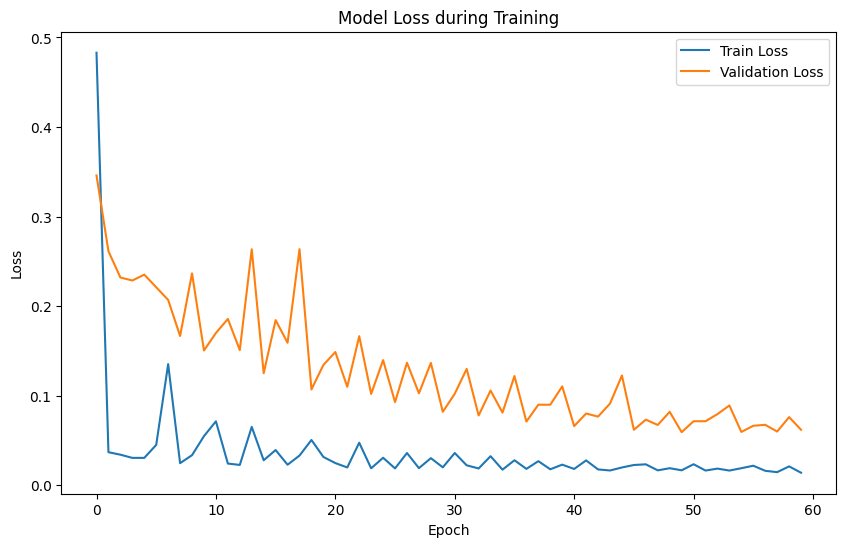

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [12]:
# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_scaled_2d = predictions_scaled.reshape(-1, 1)
# Get the last timestep of X_val
X_val_last_timestep = X_val[:, -1, :]
# Replace the first column of X_val_last_timestep with the scaled predictions.
X_val_last_timestep[:, 0] = predictions_scaled_2d[:, 0]
# unscale the predictions
predictions_rescaled = scaler.inverse_transform(X_val_last_timestep)[:, 0]

# unscale the Y_val
#Y_val_2d = Y_val.reshape(-1, 1)
#Y_val_rescaled = scaler.inverse_transform(val.iloc[n_past:, :].values)[:, 0]
Y_val_rescaled = scaler.inverse_transform(val.iloc[-len(predictions_scaled):, :].values)[:, 0]

# Calculate the error
GRU_mape_val = mean_absolute_percentage_error(Y_val_rescaled, predictions_rescaled)
GRU_rmse_val = np.sqrt(mean_squared_error(Y_val_rescaled, predictions_rescaled))
GRU_mae_val = mean_absolute_error(Y_val_rescaled, predictions_rescaled)

print(f'MAPE GRU VAL: {GRU_mape_val}')
print(f'RMSE GRU VAL: {GRU_rmse_val}')
print(f'MAE GRU VAL: {GRU_mae_val}')

MAPE GRU VAL: 0.7741535305976868
RMSE GRU VAL: 12243.173828125
MAE GRU VAL: 9032.2333984375


In [13]:
# Let's predict the test set using the best model
predictions_test_scaled = GRU_BEST_model.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


In [14]:
# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_test_scaled_2d = predictions_test_scaled.reshape(-1, 1)
# Get the last timestep of X_test
X_test_last_timestep = X_test[:, -1, :]
# Replace the first column of X_test_last_timestep with the scaled predictions.
X_test_last_timestep[:, 0] = predictions_test_scaled_2d[:, 0]
# unscale the predictions
predictions_test_rescaled = scaler.inverse_transform(X_test_last_timestep)[:, 0]

# Let's convert the predictions and Y_test to a dataframe usind the index from test
predictions_test_df = pd.DataFrame(predictions_test_rescaled, index=test.index[-len(predictions_test_rescaled):], columns=[target_variable])

# Reverse the decomposition of the time series
#predictions = recompose_time_series(predictions_test_df, decomp_dict)
predictions = predictions_test_df.copy()
Y_test_ori = df_adjusted[-len(predictions):][target_variable]


In [15]:
# Calculate the error
mape_best_GRU = mean_absolute_percentage_error(Y_test_ori, predictions)
rmse_best_GRU = np.sqrt(mean_squared_error(Y_test_ori, predictions))
mae_best_GRU = mean_absolute_error(Y_test_ori, predictions)

print(f'MAPE best GRU: {mape_best_GRU}')
print(f'RMSE best GRU: {rmse_best_GRU}')
print(f'MAE best GRU: {mae_best_GRU}')

MAPE best GRU: 1.1958410739898682
RMSE best GRU: 19268.693359375
MAE best GRU: 16316.6201171875


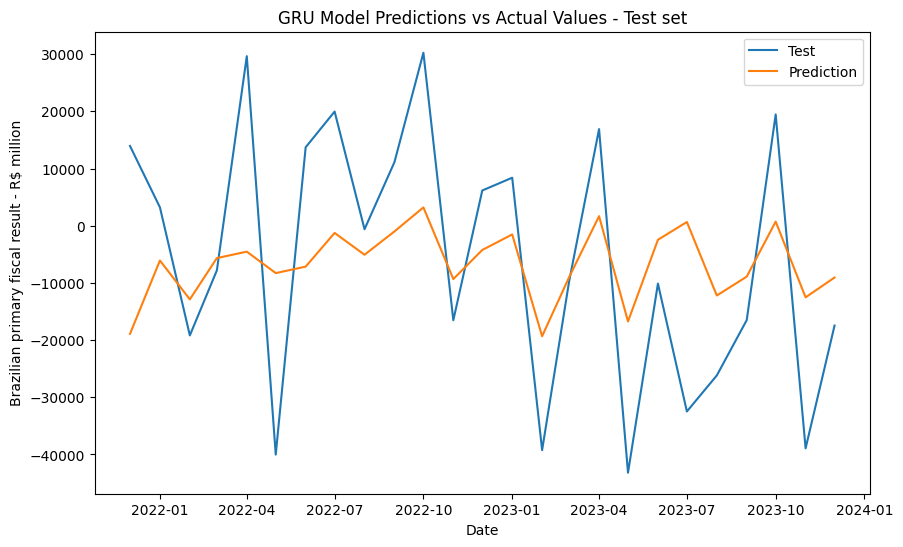

In [16]:
# Plot GRU best Model Forecast(static) vs Actuals

# Convert Y_test_rescaled to a dataframe using the test index
Y_test_rescaled_df = pd.DataFrame(Y_test_ori, index=Y_test_ori.index)
#Y_test_rescaled_df = pd.DataFrame(Y_test, index=test.index[n_past:])
# Change the column name to the target variable
Y_test_rescaled_df.columns = [target_variable]

uf.plot_prediction_vs_test(
    target_variable, 
    #train[target_variable], 
    Y_test_rescaled_df[target_variable],
    predictions,
    #predictions_test_rescaled, 
    'GRU Model Predictions vs Actual Values - Test set')

Let's forecast

In [17]:
# Adjust the index to datetime format
df_adjusted.index = pd.to_datetime(df_adjusted.index)

# New list to store the forecasts
monthly_forecasts = []

# Define a start date for the forecast
start_date = pd.Timestamp(year=2024, month=1, day=1)

for i in range(12):  # For each month in the next year
    # Define a end date for the forecast
    end_date = start_date - pd.DateOffset(months=13)
    # Define a start date 12 months before the end date
    start_date_12_months_before = end_date - pd.DateOffset(months=11)
    # Subset the dataset to get the data for the last 12 months
    data_for_prediction = df_adjusted.loc[start_date_12_months_before:end_date]
    # Scale the data
    data_for_prediction_scaled = scaler.transform(data_for_prediction)
    data_for_prediction_scaled_df = pd.DataFrame(data_for_prediction_scaled, columns=df_adjusted.columns) # convert to dataframe
    # Include the index in the train and test sets
    data_for_prediction_scaled_df.index = data_for_prediction.index
    
    # Prepare the data for the model
    X_predict = np.array([data_for_prediction_scaled_df]) # convert to numpy array
    # Predict the next month
    future_prediction_scaled = GRU_BEST_model.predict(X_predict)
    
    # Reverse the scaling
    temp_array = np.zeros((1, len(df_adjusted.columns))) # Create an array of zeros
    temp_array[0, 0] = future_prediction_scaled[0, 0] # Store the prediction in the first column

    # rescale the prediction
    future_prediction_rescaled = scaler.inverse_transform(temp_array)[0, 0]

    ### Compute confidence intervals
    # Compute squared errors for each prediction point
    predictions_array = predictions.values.flatten() # Convert the predictions to a 1D array
    squared_errors = (Y_test_ori - predictions_array) ** 2
    rmse_errors = np.sqrt(squared_errors) # Take the square root of each squared error to get the RMSE for each point
    # Compute the standard error
    error_std = np.std(rmse_errors, axis=0)
    # Apply it to your forecasts
    lower_bound = future_prediction_rescaled - 1.96 * error_std # 95% confidence interval
    upper_bound = future_prediction_rescaled + 1.96 * error_std

    # Store the prediction and bounds
    monthly_forecasts.append((future_prediction_rescaled, lower_bound, upper_bound))
    # Change the start date to the next month
    start_date += pd.DateOffset(months=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


### Forecast

In [18]:
# Convert the forecasts to a DataFrame
# Get the last date of the test set
last_test_date = Y_test_rescaled_df.index[-1]
future_dates = pd.date_range(start=last_test_date + pd.DateOffset(months=1), periods=12, freq='MS')
monthly_forecasts_df = pd.DataFrame(monthly_forecasts, index=future_dates, columns=[target_variable, 'Lower Bound', 'Upper Bound'])

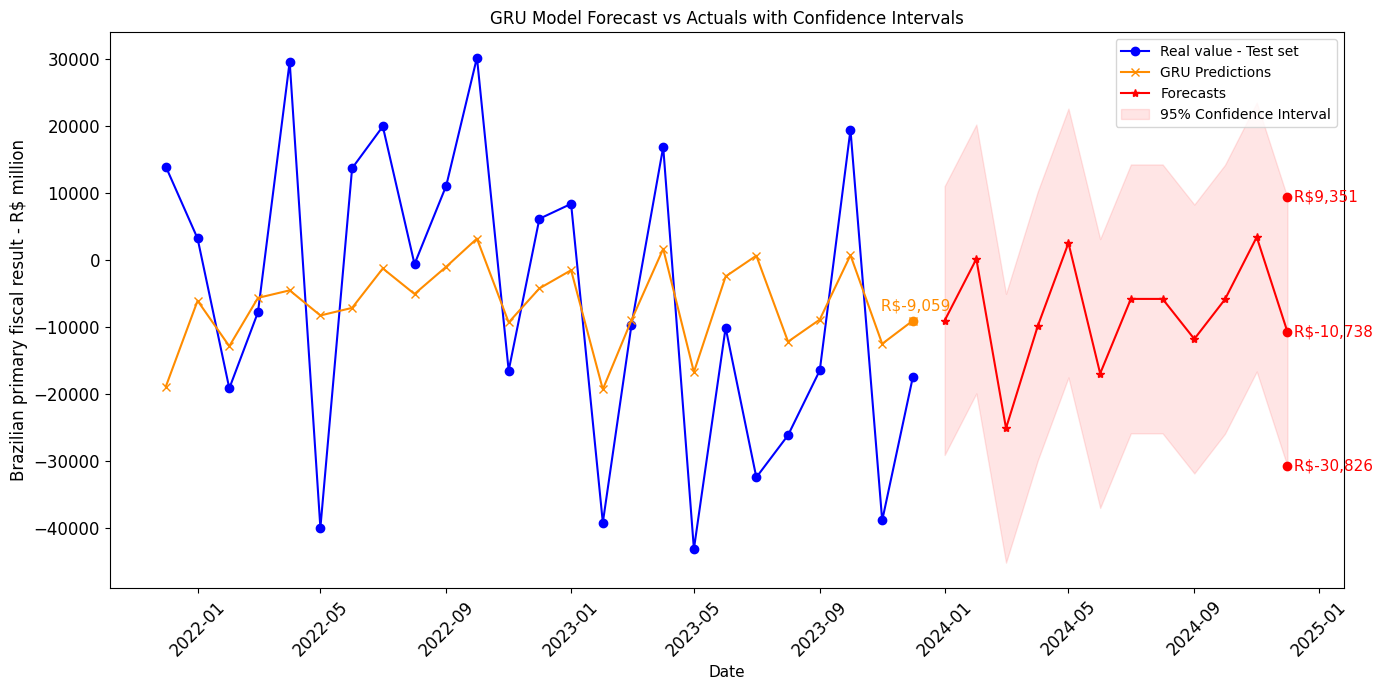

In [19]:
# Plot the actuals, test predictions, and future forecasts
plt.figure(figsize=(14, 7))
text_size = 11
# Actuals for the test set
plt.plot(Y_test_rescaled_df.index, Y_test_rescaled_df[target_variable], label='Real value - Test set', marker='o', color='blue')
# Predictions for the test set
plt.plot(predictions.index, predictions[target_variable], label='GRU Predictions', marker='x', color='darkorange')

# Future forecasts with confidence intervals
plt.plot(monthly_forecasts_df.index, monthly_forecasts_df[target_variable], label='Forecasts', marker='*', color='red')

# Confidence intervals
plt.fill_between(monthly_forecasts_df.index, 
                 monthly_forecasts_df['Lower Bound'], 
                 monthly_forecasts_df['Upper Bound'], 
                 color='red', alpha=0.1, label='95% Confidence Interval')

# Annotate the last predicted observation
last_predicted_date = predictions.index[-1]
last_predicted_value = predictions[target_variable].iloc[-1]
plt.scatter(last_predicted_date, last_predicted_value, color='darkorange')  # Highlight the last point
# Annotate the last predicted observation
offset = 1000 #Offset the text so it doesn't overlap with the point
plt.text(last_predicted_date, last_predicted_value+offset, f' R${last_predicted_value:,.0f}', fontsize = text_size, color='darkorange', va='bottom', ha='center')

# Annotate the last forecast observation - Complete Series
last_forecast_date = monthly_forecasts_df.index[-1]
last_forecast_value = monthly_forecasts_df[target_variable].iloc[-1]
last_upper_bound_value = monthly_forecasts_df['Upper Bound'].iloc[-1]
last_lower_bound_value = monthly_forecasts_df['Lower Bound'].iloc[-1]
plt.scatter(last_forecast_date, last_forecast_value, color='red')  # Highlight the last point
plt.scatter(last_forecast_date, last_upper_bound_value, color='red')
plt.scatter(last_forecast_date, last_lower_bound_value, color='red')
# Annotate the last forecast observation - Complete Series
offset_horizontal = timedelta(days=2) #Offset the text so it doesn't overlap with the point
plt.text(last_forecast_date+offset_horizontal, last_upper_bound_value, f' R${last_upper_bound_value:,.0f}', fontsize = text_size, color='red', va='center', ha='left')
plt.text(last_forecast_date+offset_horizontal, last_lower_bound_value, f' R${last_lower_bound_value:,.0f}', fontsize = text_size, color='red', va='center', ha='left')
plt.text(last_forecast_date+offset_horizontal, last_forecast_value, f' R${last_forecast_value:,.0f}', fontsize = text_size, color='red', va='center', ha='left')
plt.title('GRU Model Forecast vs Actuals with Confidence Intervals')
plt.xlabel('Date', fontsize=text_size)
plt.ylabel('Brazilian primary fiscal result - R$ million', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()


In [22]:
monthly_forecasts_df

,ECO_fiscal_result_month,Lower Bound,Upper Bound
2024-01-01,-9059.051461,-29147.901110,11029.798187
2024-02-01,150.571552,-19938.278097,20239.421200
2024-03-01,-25140.494975,-45229.344624,-5051.645327
2024-04-01,-9875.983081,-29964.832729,10212.866567
2024-05-01,2542.011068,-17546.838581,22630.860716
2024-06-01,-16962.636297,-37051.485946,3126.213351
2024-07-01,-5814.779723,-25903.629372,14274.069925
2024-08-01,-5816.221202,-25905.070850,14272.628447
2024-09-01,-11805.589873,-31894.439522,8283.259775
2024-10-01,-5869.149829,-25957.999477,14219.699820


In [20]:
import shap
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() # Disable TF2 behavior to use SHAP



c:\Users\augus\Meu Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Instructions for updating:
non-resource variables are not supported in the long term


In [21]:
# Calcular os valores SHAP
sample = X_test.copy()
shap_values = gru_explainer.shap_values(sample)

# Visualizar as contribuições
shap.summary_plot(
  data_loader.inverse_transform(shap_values[0]), 
  data_loader.inverse_transform(sample), 
  feature_names=data_loader.get_values().columns
)

NameError: name 'gru_explainer' is not defined